In [ ]:
import tensorflow as tf
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    for gpu in gpus:
        print("Found GPU:", gpu)
else:
    print("No GPU detected")
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        logical_gpus = tf.config.experimental.list_logical_devices('GPU')
        print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
    except RuntimeError as e:
        print(e)


Found GPU: PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')
1 Physical GPUs, 1 Logical GPUs


In [ ]:
import os
import numpy as np
from sklearn.model_selection import train_test_split
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam

In [ ]:
base_dir = "C:\/Users\/khors\/Downloads\/DeepFake Face Recognition\/Datasets\/dfdc_train_part_00"

real_dir = os.path.join(base_dir, 'real')
fake_dir = os.path.join(base_dir, 'fake')

real_frames = os.path.join(real_dir, "real_frames")
fake_frames = os.path.join(fake_dir, "fake_frames")

real_faces = os.path.join(real_dir, "real_faces")
fake_faces = os.path.join(fake_dir, "fake_faces")

real_faces_dir = os.path.join(real_dir, "real_faces")
fake_faces_dir = os.path.join(fake_dir, "fake_faces")

train_dir = os.path.join(base_dir, "train")
test_dir = os.path.join(base_dir, "test")

In [ ]:
train_data_generator = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest',
    validation_split=0.2
)

validation_data_generator = ImageDataGenerator(rescale=1./255)

In [ ]:
train_generator = train_data_generator.flow_from_directory(train_dir,
                                                    target_size=(224, 224),
                                                    batch_size=20,
                                                    class_mode='binary',
                                                          shuffle=False)

test_generator = validation_data_generator.flow_from_directory(test_dir,
                                                  target_size=(224, 224),
                                                  batch_size=20,
                                                  class_mode='binary',
                                                            shuffle=False)

Found 10118 images belonging to 2 classes.
Found 2531 images belonging to 2 classes.


### Model Creation

In [ ]:
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

def create_roc_curve(test_generator):
    # Make predictions on the test dataset
    y_pred = model.predict(test_generator)

    # Compute ROC curve and ROC area for each class
    fpr, tpr, _ = roc_curve(test_generator.classes, y_pred)
    roc_auc = auc(fpr, tpr)

    # Plot ROC curve
    plt.figure()
    lw = 2
    plt.plot(fpr, tpr, color='darkorange',
             lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)
    plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) Curve')
    plt.legend(loc="lower right")
    return plt

In [ ]:
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

def create_confusion_matrix(test_generator):
    # Predict the classes for the test data
    y_pred = model.predict(test_generator)
    y_pred_classes = (y_pred > 0.5).astype(int)

    # Get the true labels for the test data
    y_true = test_generator.classes

    # Calculate the confusion matrix
    conf_matrix = confusion_matrix(y_true, y_pred_classes)

    # Plot the confusion matrix
    plt.figure(figsize=(8, 6))
    sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['Real', 'Fake'], yticklabels=['Real', 'Fake'])
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.title('Confusion Matrix')
    return plt

In [ ]:
from sklearn.metrics import classification_report

def create_classification_report(test_generator):
    # Get the model predictions on the test data
    y_pred = model.predict(test_generator)

    # Convert the predicted probabilities to class labels (0 or 1)
    y_pred_binary = (y_pred > 0.5).astype(int)

    # Get the true labels from the test data generator
    y_true = test_generator.classes

    return classification_report(y_true, y_pred_binary)

In [ ]:
from sklearn.utils import shuffle
from imblearn.over_sampling import RandomOverSampler
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import Adam

def create_model(train_generator, test_generator, learning_rate=0.001, epochs=20):


    # Load ResNet50 pre-trained on ImageNet without the top layer
    base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

    # Freeze the layers of the base model
    for layer in base_model.layers:
        layer.trainable = False

    x = base_model.output
    x = GlobalAveragePooling2D()(x)  # Add a global spatial average pooling layer
    x = Dense(1024, activation='relu')(x)  # Add a fully-connected layer
    predictions = Dense(1, activation='sigmoid')(x)  # Add a logistic layer for binary classification

    model = Model(inputs=base_model.input, outputs=predictions)

    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    batch_size=32
    # Train the model
    history = model.fit(
        train_generator,
        validation_data=test_generator,
        epochs=epochs,
        steps_per_epoch=train_generator.n // batch_size,
        batch_size=batch_size,
        callbacks=[EarlyStopping(patience=3, restore_best_weights=True)]
    )

    return model, history


In [ ]:
print(sum(train_generator.classes))

4716


In [ ]:
with tf.device("/GPU:0"):
    model, history = create_model(train_generator, test_generator)

# Evaluate the model on the test data
test_loss, test_acc = model.evaluate(test_generator)
print("Test Loss:", test_loss)
print("Test Accuracy:", test_acc)

Epoch 1/20
316/316 [==============================] - 82s 246ms/step - loss: 0.8733 - accuracy: 0.5699 - val_loss: 0.7057 - val_accuracy: 0.4662
Epoch 2/20
316/316 [==============================] - 76s 239ms/step - loss: 0.7337 - accuracy: 0.4753 - val_loss: 0.6898 - val_accuracy: 0.5342
Epoch 3/20
316/316 [==============================] - 75s 237ms/step - loss: 0.7097 - accuracy: 0.4745 - val_loss: 0.6909 - val_accuracy: 0.5338
Epoch 4/20
316/316 [==============================] - 75s 236ms/step - loss: 0.6943 - accuracy: 0.4881 - val_loss: 0.6927 - val_accuracy: 0.5338
Epoch 5/20
127/127 [==============================] - 9s 69ms/step - loss: 0.6898 - accuracy: 0.5342
Test Loss: 0.6897909045219421
Test Accuracy: 0.534176230430603


In [ ]:
import matplotlib.pyplot as plt

acc = history.history['accuracy']   #if you are usinf tf version 1.x then use 'acc' instead of 'accuracy'
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

fig = plt.subplots(figsize=(30, 10))

plt.subplot(1, 2, 1)
plt.plot(acc)
plt.plot(val_acc)
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['Training Accuracy', 'Validation Accuracy'])

plt.subplot(1, 2, 2)
plt.plot(loss)
plt.plot(val_loss)
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Training Loss', 'Validation Loss'])

plt.show()

127/127 [==============================] - 9s 64ms/step


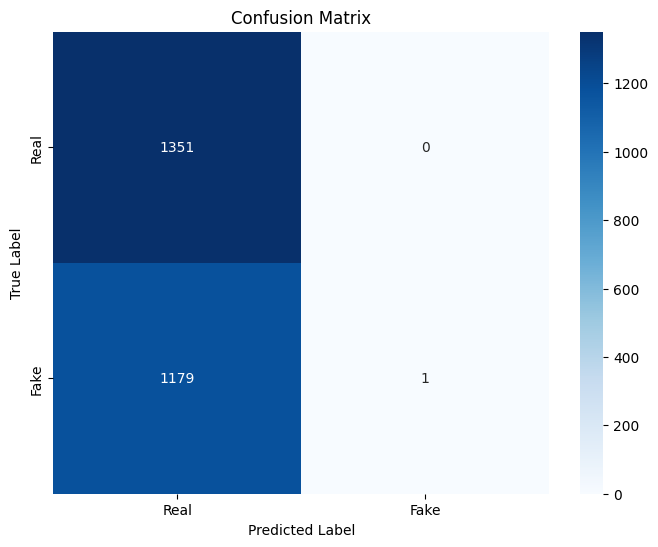

In [ ]:
create_confusion_matrix(test_generator).show()

127/127 [==============================] - 8s 66ms/step


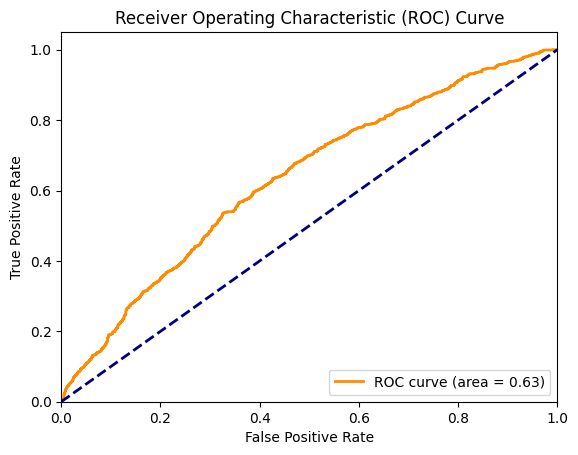

In [ ]:
create_roc_curve(test_generator).show()

In [ ]:
model.save("C:\/Users\/khors\/Downloads\/DeepFake Face Recognition\/Saved Models\/ResNet.h5")

### Regularizing the Model

In [ ]:
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Flatten, Dropout
from tensorflow.keras.regularizers import l2
from tensorflow.keras.optimizers import Adam

def create_regularized_resnet_model(input_shape, num_classes, learning_rate=0.001, dropout_rate=0.5, l2_penalty=0.01):
    # Load the pre-trained ResNet50 model without the top layer
    base_model = ResNet50(weights='imagenet', include_top=False, input_shape=input_shape)

    # Freeze the layers of the base model
    for layer in base_model.layers:
        layer.trainable = False

    # Add custom top layers for classification
    x = base_model.output
    x = GlobalAveragePooling2D()(x)  # Add a global spatial average pooling layer
    x = Dense(1024, activation='relu')(x)  # Add a fully-connected layer
    predictions = Dense(num_classes, activation='sigmoid')(x)

    # Create the final model
    model = Model(inputs=base_model.input, outputs=predictions)

    # Compile the model
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

    return model

# Example usage:
input_shape = (224, 224, 3)  # Adjust input shape as per your requirements
model = create_regularized_resnet_model(input_shape, 1)


C:\Users\khors\miniconda3\envs\test\lib\site-packages\keras\optimizers\optimizer_v2\adam.py:114: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


In [ ]:
train_generator.n

10118

In [ ]:
with tf.device("/GPU:0"):
    batch_size=32
    # Train the model
    history = model.fit(
        train_generator,
        validation_data=test_generator,
        epochs=20,
        steps_per_epoch=train_generator.n // batch_size,
        batch_size=batch_size,
        callbacks=[EarlyStopping(patience=3, restore_best_weights=True)]
    )

Epoch 1/20
135/316 [===========>..................] - ETA: 39s - loss: 0.9951 - accuracy: 0.5430

KeyboardInterrupt: 

In [ ]:
model.save("C:\/Users\/khors\/Downloads\/DeepFake Face Recognition\/Saved Models\/ResNet_Regularization.h5")

In [ ]:
# Evaluate the model on the test data
test_loss, test_acc = model.evaluate(test_generator)
print("Test Loss:", test_loss)
print("Test Accuracy:", test_acc)

In [ ]:
create_confusion_matrix(test_generator)

In [ ]:
print(create_classification_report(test_generator))

In [ ]:
create_roc_curve(test_generator)

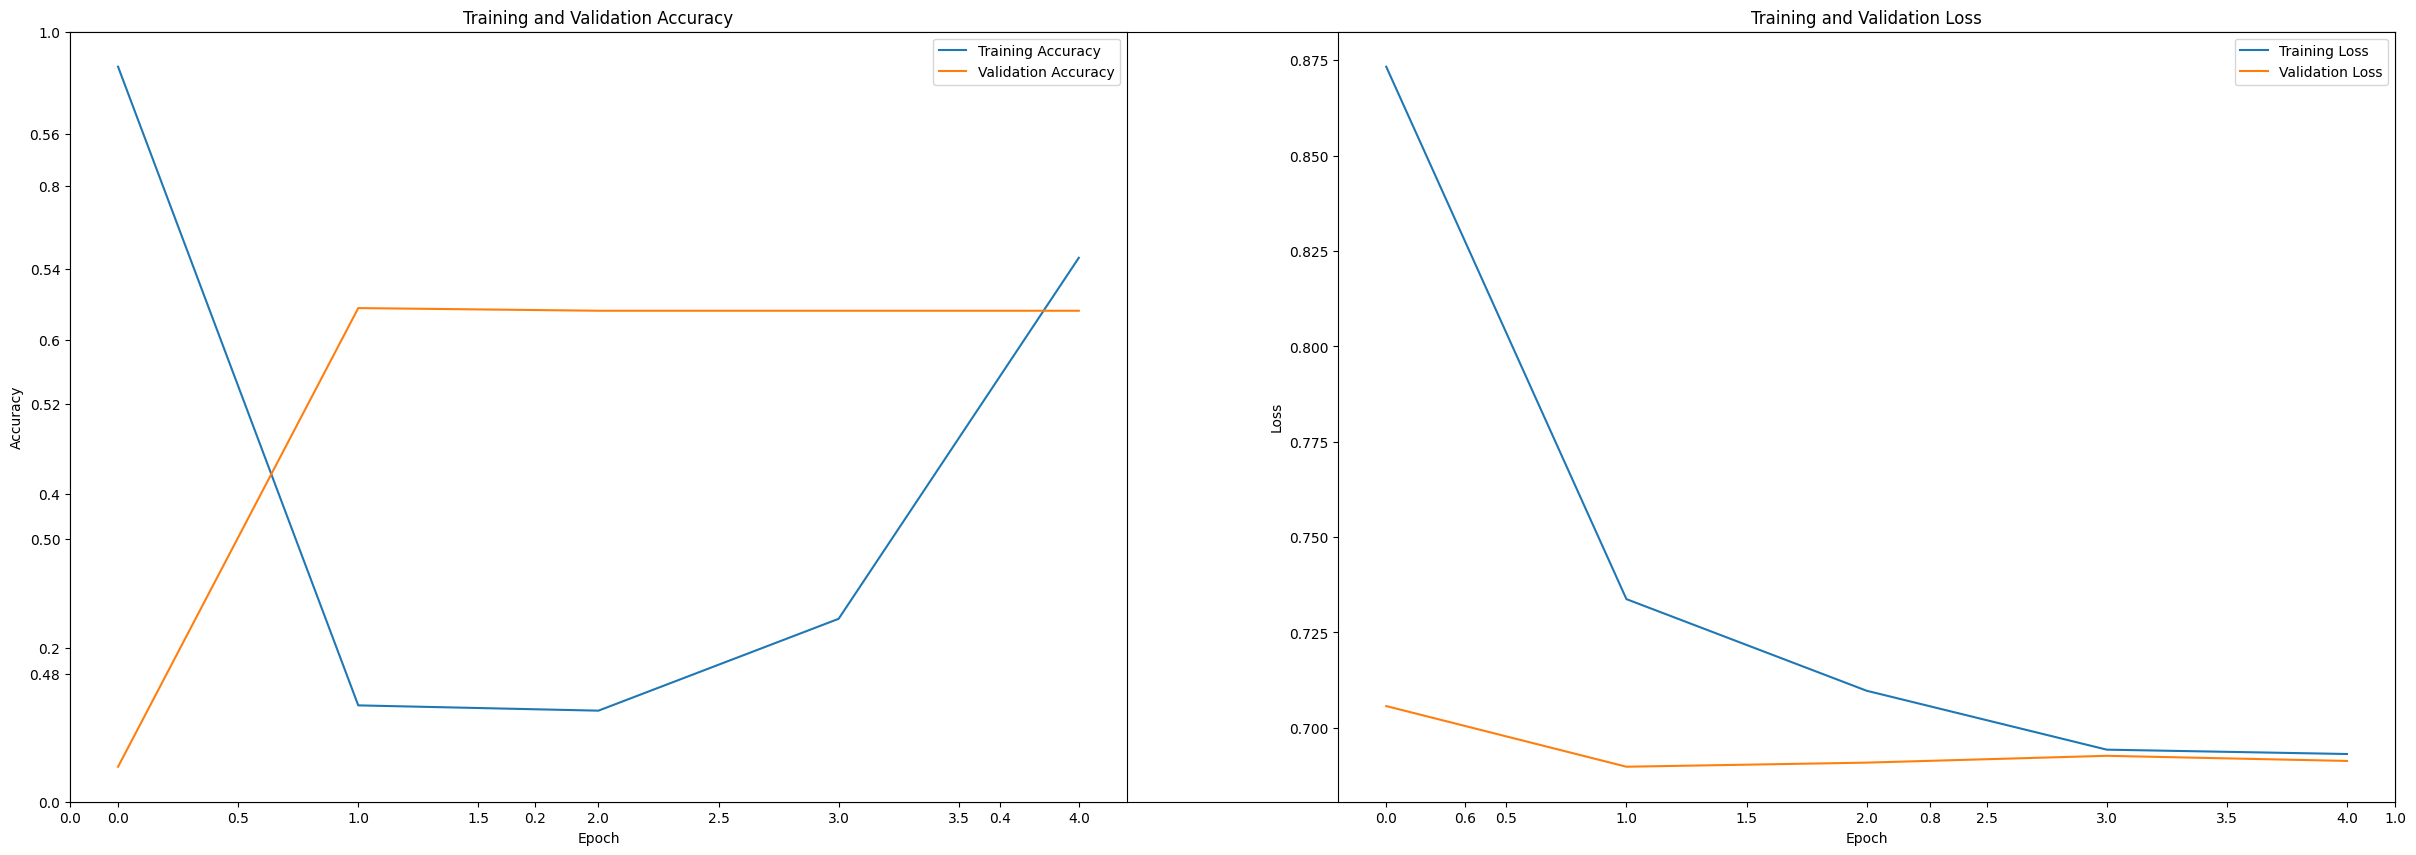

In [ ]:
import matplotlib.pyplot as plt

acc = history.history['accuracy']   #if you are usinf tf version 1.x then use 'acc' instead of 'accuracy'
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

fig = plt.subplots(figsize=(30, 10))

plt.subplot(1, 2, 1)
plt.plot(acc)
plt.plot(val_acc)
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['Training Accuracy', 'Validation Accuracy'])

plt.subplot(1, 2, 2)
plt.plot(loss)
plt.plot(val_loss)
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Training Loss', 'Validation Loss'])

plt.show()